# Title
### Time Series Forecasting

## Hypothesis
 
 Null Hypothesis: The type of holiday does not have any significant on the increase of sales
 
 Alternative Hypothesis: The type of holiday has significant impact on the increase in sales

 ## Hypothesis Testing
Null Hypothesis (H0): The promotional activities have a significant impact on store sales.

Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.
 
 ## Questions

The questions below are to be answered. Do note that, you are free to draw more hypothesis from the data.

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Your task is to build a model that more accurately predicts the unit sales for thousands of items.

# Importing Liberaries

In [2]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot  as plt 
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px

# impoerting and reading sql file
import pyodbc
from dotenv import dotenv_values



# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import ttest_ind
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from statsmodels.tsa.seasonal import STL


# Feature processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima import auto_arima




# cancelling warning messages
import warnings
warnings.filterwarnings("ignore")



#### Loading the data set from SQL server

In [3]:
# # create dotenv environment
environment_variables = dotenv_values()

# get varriable from .env created
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password =environment_variables.get("PASSWORD")




In [4]:
# create  connections to the server using sever name, username, database and password

conn_str = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server 


connection = pyodbc.connect(conn_str)
# read data from oil table
query = "SELECT * From dbo.oil"
oil_df = pd.read_sql(query,connection)

# read data from holiday table 
query2= "SELECT * from dbo.holidays_events"
holiday_df=pd.read_sql(query2,connection)

# read data from store table
query3= "SELECT * from dbo.stores"
stores_df=pd.read_sql(query3,connection)

In [4]:
#  Display dbo oil
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [5]:
#  Display the holiday events
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
#  Display stores
stores_df.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


#  loading of csv data set

In [5]:
# reading the csv file and seting the date as date type
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
transactions = pd.read_csv("transactions.csv")
sample_data = pd.read_csv("sample_submission.csv")

In [8]:
train_data
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Data Exploration and Understanding

Exploring and understanding the sql data

In [10]:
# Display summary statistics for the holiday events
holiday_summary = holiday_df.describe(include=object).T

# Display summary statistics for the oil price
oil_summary = oil_df.describe()

# Display summary statistics for the stotres
stores_summary = stores_df.describe(include=object).T

# Display results
print("statistics summary for holiday event:" )
display(holiday_summary)
print("=" *50)

print("Statistics summary for oil price")
display(oil_summary)
print("=" *50)

print("statistics summary of stores")
display(stores_summary)


statistics summary for holiday event:


,count,unique,top,freq
date,350,312,2014-06-25,4
type,350,6,Holiday,221
locale,350,3,National,174
locale_name,350,24,Ecuador,174
description,350,103,Carnaval,10


Statistics summary for oil price


,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190001
25%,46.405001
50%,53.189999
75%,95.660000
max,110.620003


statistics summary of stores


,count,unique,top,freq
city,54,22,Quito,18
state,54,16,Pichincha,19
type,54,5,D,18


In [11]:
# Display infomation for the holiday events

# Display info for the oil price
print("Display holiday info:" )
print("=" *50)
holiday_info =holiday_df.info()
display(holiday_info)

# Display info for the stotres
print("Display oil info:" )
print("=" *50)
oil_info =oil_df.info()
display(oil_info)

# Display info for the stotres
print("Display stores info:" )
print("=" *50)
stores_info = stores_df.info()
display(stores_info)


Display holiday info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


None

Display oil info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


None

Display stores info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


None

In [12]:
# Display the null values in Holiday Events

print("display Null values in Holidyas event:")
print("=" * 50)
holiday_isnull = holiday_df.isna().sum()
display(holiday_isnull)

print("display Null values in oil price:")
print("=" * 50)
oil_isnull = oil_df.isna().sum()
display(oil_isnull)

print("display Null values in stores data:")
print("=" * 50)
stores_isnull = stores_df.isna().sum()
display(stores_isnull)

display Null values in Holidyas event:


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

display Null values in oil price:


date           0
dcoilwtico    43
dtype: int64

display Null values in stores data:


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [13]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holiday_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")

print(f"Transactions Dataset: {transactions.shape}")
print(f"Train Dataset: {train_data.shape}")


Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)
Train Dataset: (3000888, 6)


#### Exploring and understanding the csv data "transaction", "train" and "test data"

In [14]:
# Display summary statistics for object columns in transaction data
transactions_summary = transactions.describe()

# Display summary statistics for object colums in train data
train_summary = train_data.describe(include=object).T

# Display summary statistics for object columns in test data
test_summary = test_data.describe()

# Display results
print("statistics summary for transactions:" )
display(transactions_summary)
print("=" *50)

print("Statistics summary for train data")
display(train_summary)
print("=" *50)

print("statistics summary of test")
display(test_summary)


statistics summary for transactions:


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


Statistics summary for train data


,count,unique,top,freq
date,3000888,1684,2013-01-01,1782
family,3000888,33,AUTOMOTIVE,90936


statistics summary of test


,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [15]:
# Display infomation for the transactions

# Display info for the oil price
print("Display holiday info:" )
print("=" *50)
transactions_info =transactions.info()
display(transactions_info)

# Display info for the train data set
print("Display train info:" )
print("=" *50)
train_info = train_data.info()
display(train_info)

# Display info for the stotres
print("Display test info:" )
print("=" *50)
test_info = test_data.info()
display(test_info)

Display holiday info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


None

Display train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


None

Display test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


None

In [16]:
# Display the null values in transactions data set

print("display Null values in transactions:")
print("=" * 50)
transactions_isnull = transactions.isna().sum()
display(transactions_isnull)

print("display Null values in train data set:")
print("=" * 50)
train_isnull = train_data.isna().sum()
display(train_isnull)

print("display Null values in test data:")
print("=" * 50)
test_isnull = test_data.isna().sum()
display(test_isnull)

display Null values in transactions:


date            0
store_nbr       0
transactions    0
dtype: int64

display Null values in train data set:


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

display Null values in test data:


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [17]:
# Print out the shape of data sets
print(f"Transactions Dataset: {transactions.shape}")
print(f"Train Dataset: {train_data.shape}")
print(f"Test Dataset: {test_data.shape}")

Transactions Dataset: (83488, 3)
Train Dataset: (3000888, 6)
Test Dataset: (28512, 5)


<b> Handling the missing values in dcoilwtico column in oil data set <b>

In [6]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='backfill')

In [19]:
# check if there is missing values in dcoilwtico column
oil_df.isna().sum()

date          0
dcoilwtico    0
dtype: int64

<b> function to creating year and month column on the tables

In [20]:
# function to add year and momnth column to the table

def add_year_month_(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # Adjust the format according to your data
    df['year']= df["date"].dt.year
    df['month']=df["date"].dt.month
    

add_year_month_(train_data)
add_year_month_(holiday_df)
add_year_month_(oil_df)
add_year_month_(transactions)

# visualization of Data
<b> Univarient

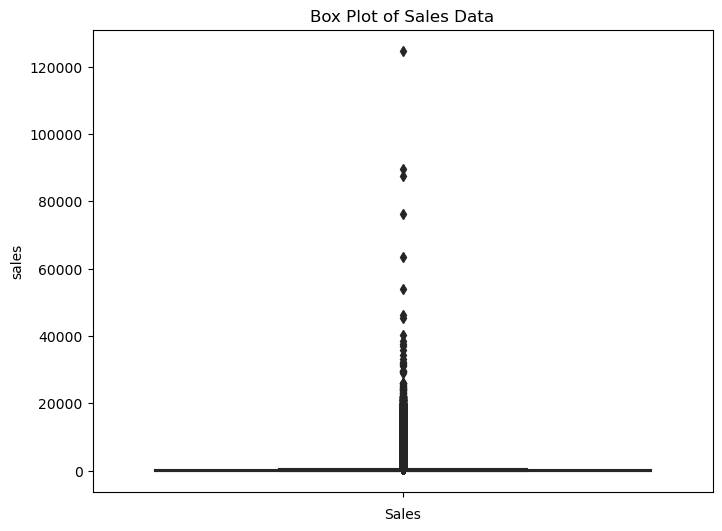

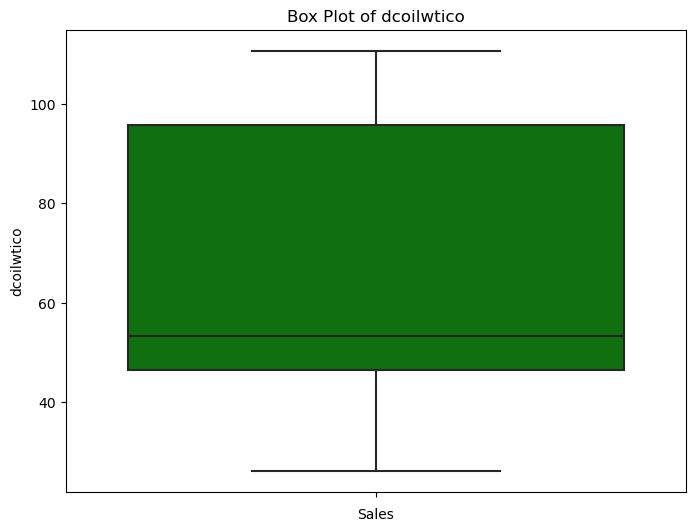

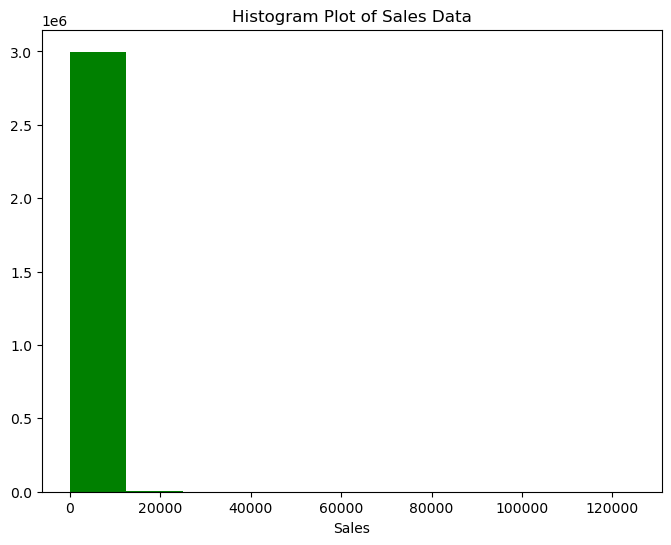

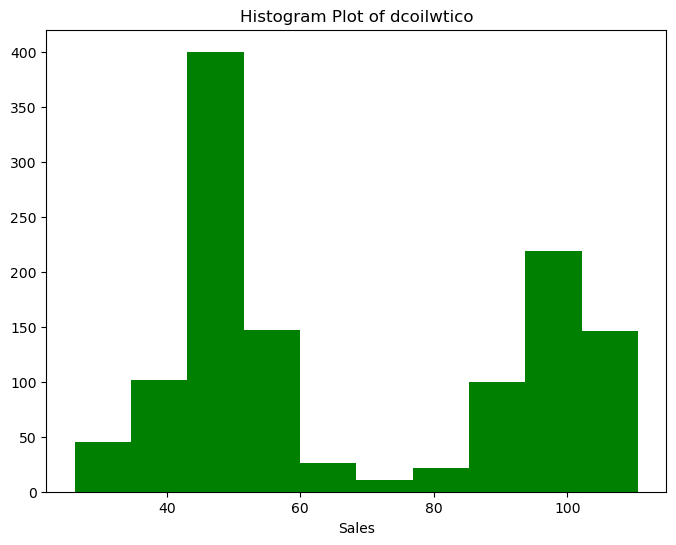

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(y="sales", data=train_data, color='green')  # vert=False for horizontal box plot
plt.title('Box Plot of Sales Data')
plt.xlabel('Sales')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(y='dcoilwtico', data=oil_df, color='green')  # vert=False for horizontal box plot
plt.title('Box Plot of dcoilwtico')
plt.xlabel('Sales')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(x= 'sales', data=train_data, color='green')  # vert=False for horizontal box plot
plt.title('Histogram Plot of Sales Data')
plt.xlabel('Sales')
plt.show()
plt.figure(figsize=(8, 6))
plt.hist(x= 'dcoilwtico',data= oil_df, color='green')  # vert=False for horizontal box plot
plt.title('Histogram Plot of dcoilwtico')
plt.xlabel('Sales')
plt.show()

## Bivariant Analysis

<b> Store distribution by state

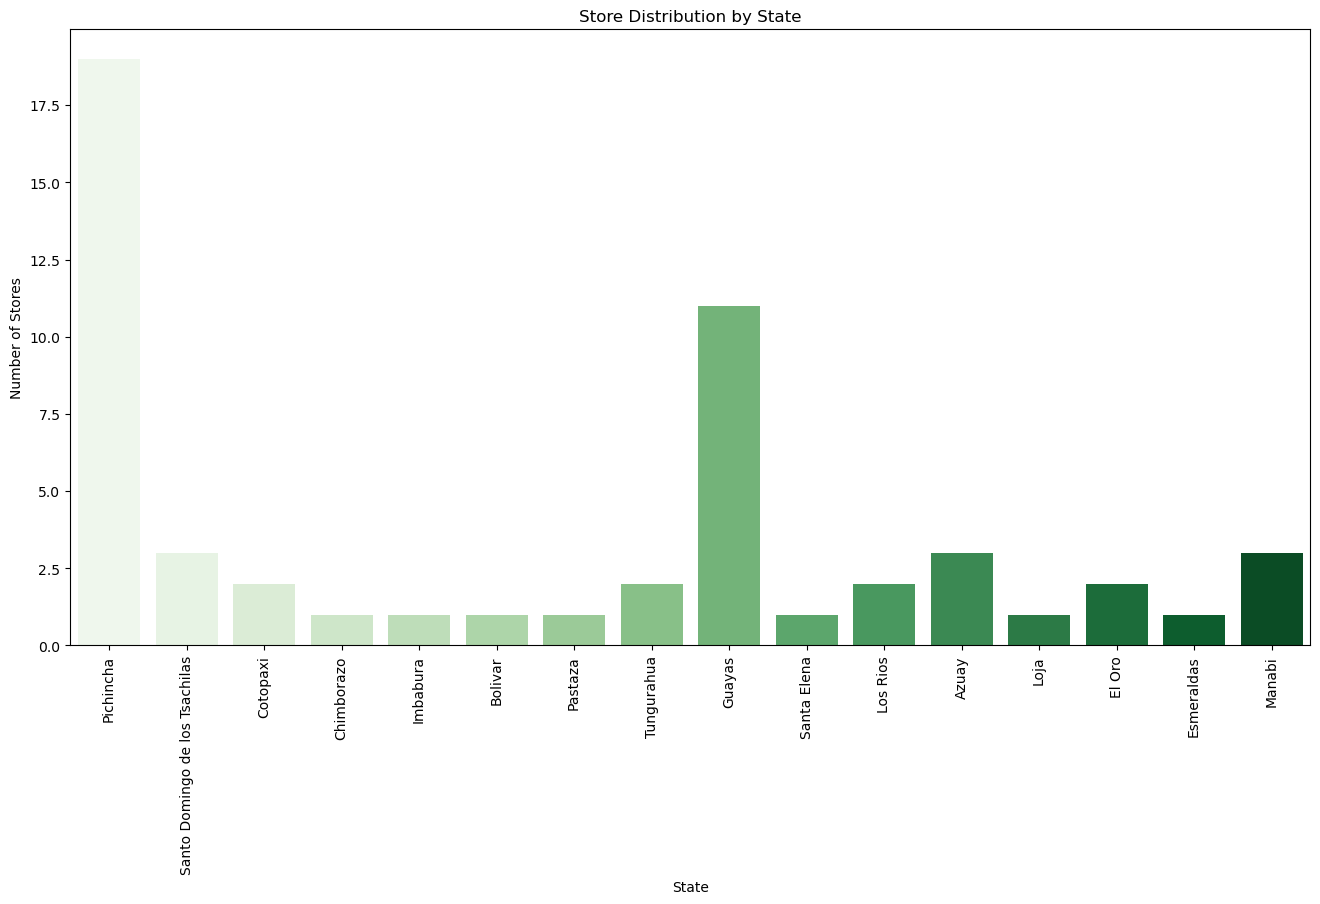

In [22]:
plt.figure(figsize=(16, 8))  # Adjust the width as needed
sns.countplot(x='state', data=stores_df, palette="Greens")
plt.xticks(rotation=90)
plt.title('Store Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Stores')
plt.show()

#### To understand the frequency of different types of holiday event

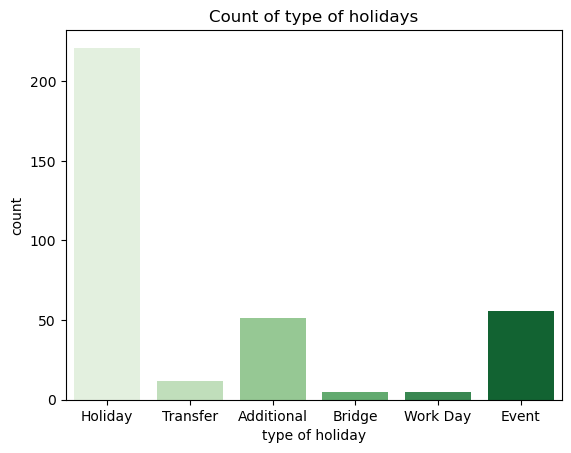

In [23]:
# to understand the frequency of holiday
# change date column to date time
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.set_index("date")
sns.countplot(x="type", data=holiday_df, palette='Greens')
plt.xlabel("type of holiday")
plt.title("Count of type of holidays")
plt.show()

<b> Checking the sales over the years

In [24]:
# Group the data by date and calculate the total sales
daily_sales = train_data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

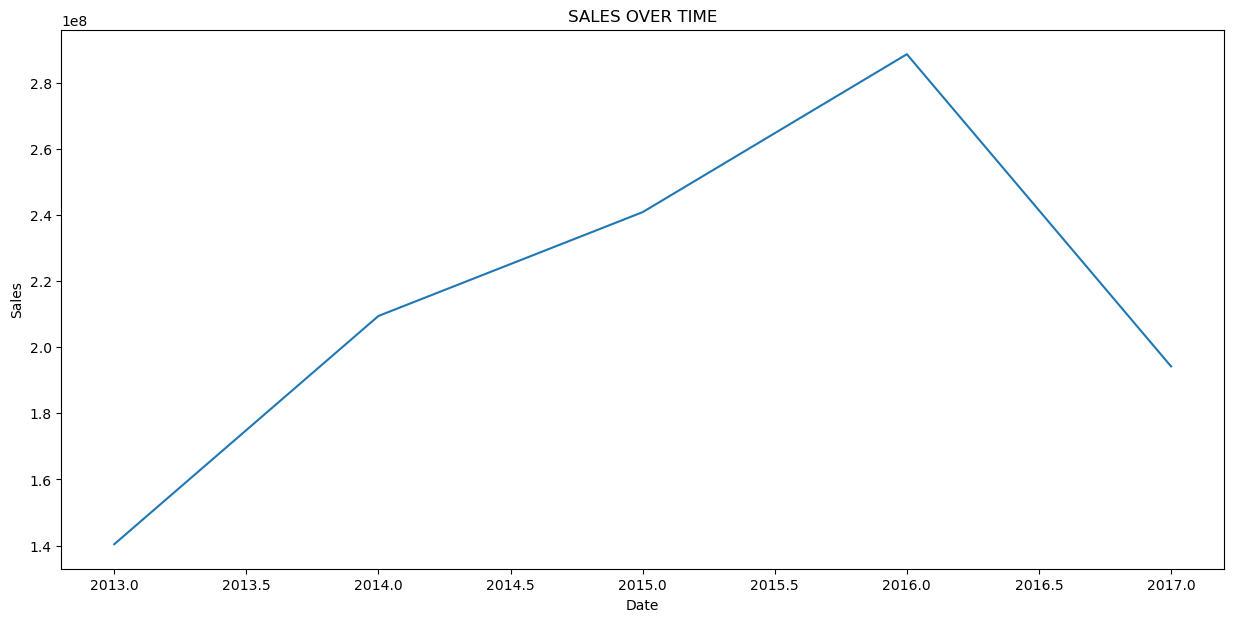

In [25]:
# change date column to date time
train_data['date'] = pd.to_datetime(train_data['date'])
#  add year and month column to the table
add_year_month_(train_data)
sales_time = train_data.groupby("year").sales.sum().reset_index()
sales_time = sales_time.set_index("year")
sales_time.plot(legend=False, figsize=(15, 7))

plt.title("SALES OVER TIME")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.style.use("fivethirtyeight")
plt.show()

From our visualization there has been increase in the sales of product fro 2013 to first half of 2016 and sfter the sales started droping till 2017, which will still more analysis to understand the sudden drop in the sales

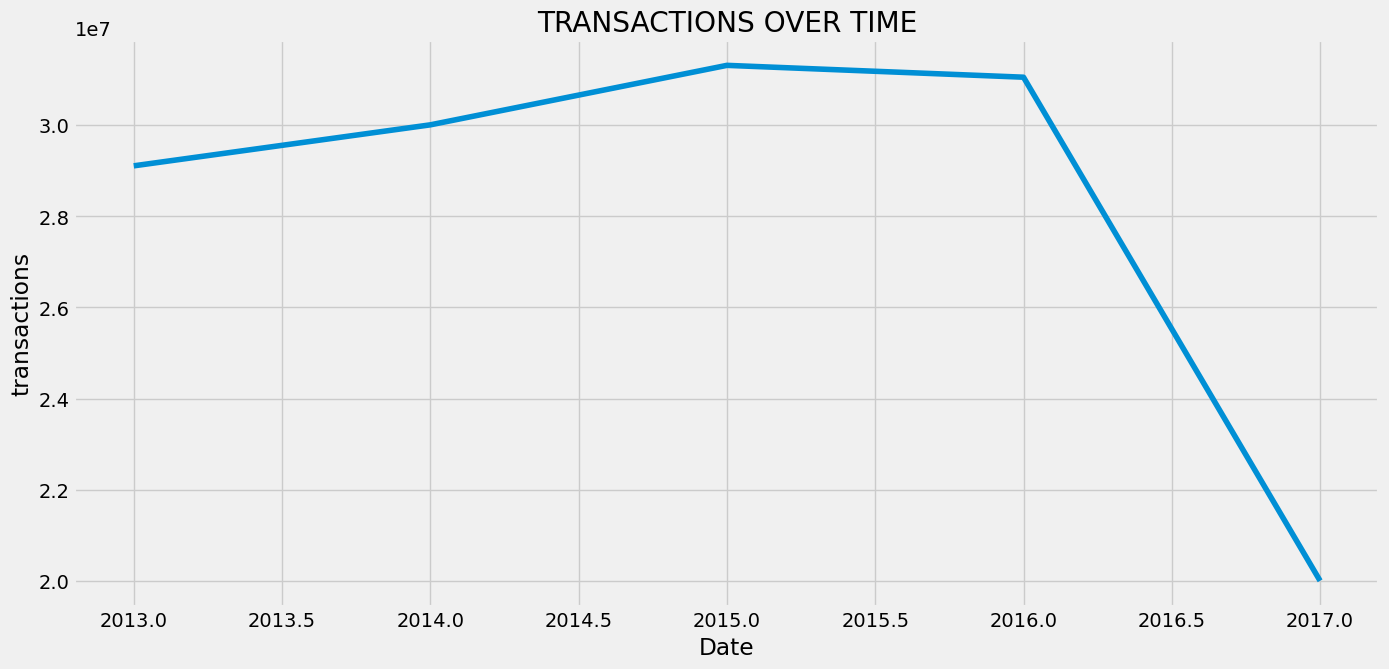

In [26]:
# change date column to date time
transactions['date'] = pd.to_datetime(transactions['date'])
#  add year and month column to the table
add_year_month_(transactions)
sales_time = transactions.groupby("year").transactions.sum().reset_index()
sales_time = sales_time.set_index("year")
sales_time.plot(legend=False, figsize=(15, 7))

plt.title("TRANSACTIONS OVER TIME")
plt.ylabel("transactions")
plt.xlabel("Date")
plt.style.use("fivethirtyeight")
plt.show()

From our visualization there has been increase in the sales of product fro 2013 to first half of 2016 and sfter the sales started droping till 2017, which will still more analysis to understand the sudden drop in the sales

# Identify regions with more or fewer holidays.

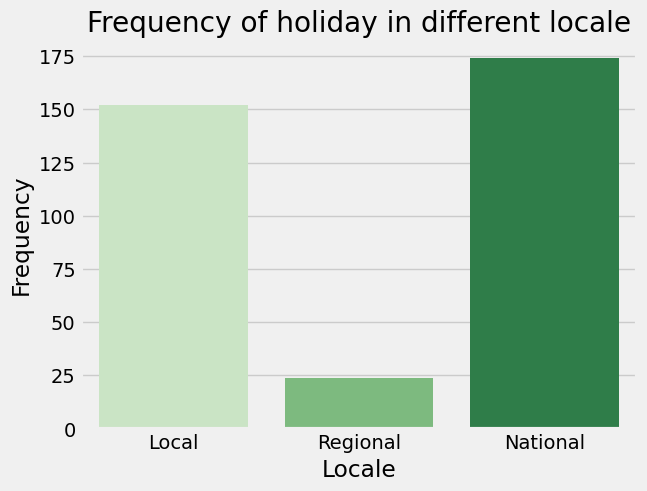

In [27]:
sns.countplot(x='locale', data=holiday_df, palette="Greens")
plt.title('Frequency of holiday in different locale')
plt.xlabel('Locale')
plt.ylabel("Frequency")
plt.show()

<b> Distribution of holiday in different months of the year

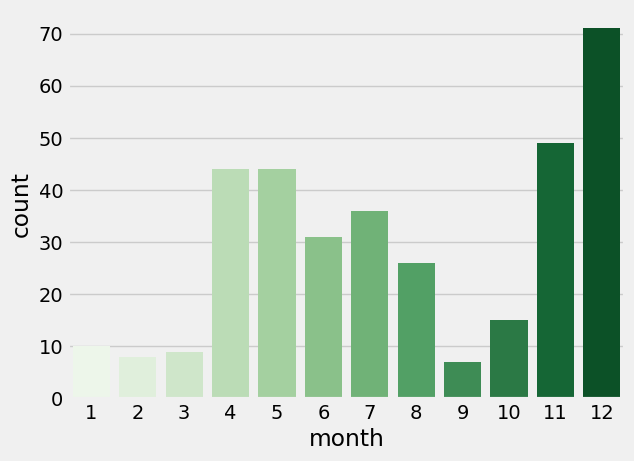

In [28]:
# Distribusion of holidays over different months of the year

sns.countplot(x="month", data=holiday_df, palette= 'Greens')
plt.show()

### sales of differentm products in different cluster

In [29]:
stores_clustter= stores_df.groupby('type')['cluster'].sum().reset_index()
stores_clustter= stores_clustter.sort_values(by='cluster', ascending=False)
stores_clustter

,type,cluster
3,D,123
2,C,122
0,A,111
1,B,62
4,E,40


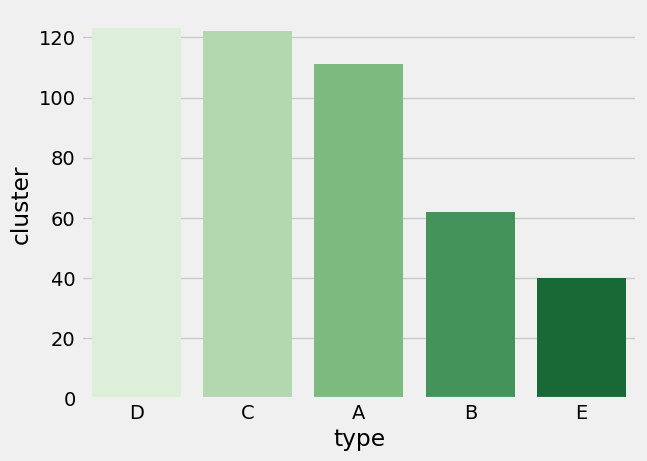

In [30]:
types = stores_df['type']

counts = ["types", "clusters"]
sns.barplot(x="type", y='cluster', data=stores_clustter, palette = 'Greens')

plt.show()

### Visualizing Changes in Crude Oil Prices over Time

<Figure size 1500x1000 with 0 Axes>

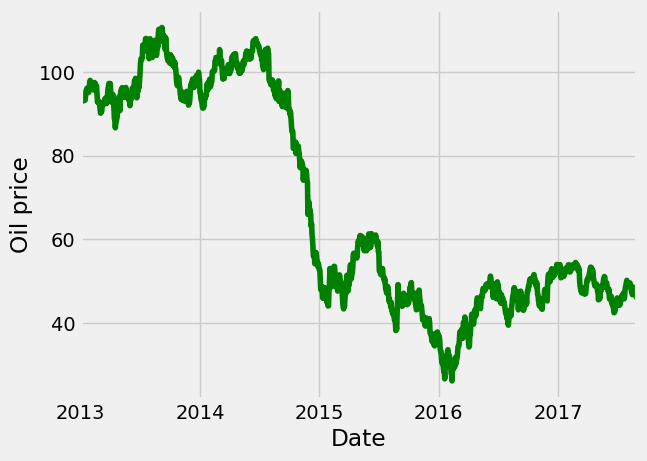

In [31]:
# change date column to date time
oil_df['date'] = pd.to_datetime(oil_df['date'])
#  add year and month column to the table
add_year_month_(oil_df)

oil_df.set_index("date")
plt.figure(figsize=(15,10))
oil_df.plot(x="date", y="dcoilwtico", color="green", legend=False)
plt.xlabel("Date")
plt.ylabel("Oil price")
plt.style.use("fivethirtyeight")
plt.show()

#  Using a pie chart to give an overview of how common it is for holidays to be transferred.

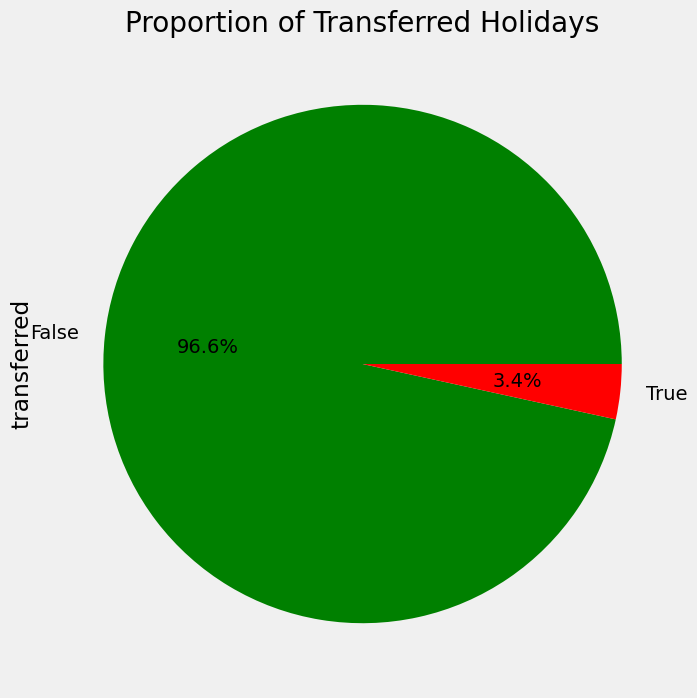

In [32]:
plt.figure(figsize=(8, 8))
holiday_df['transferred'].value_counts().plot.pie(autopct='%1.1f%%', colors='green')
plt.title('Proportion of Transferred Holidays')
plt.show()

<b> Checking for seanality of sales of products over the years

<Figure size 1500x1000 with 0 Axes>

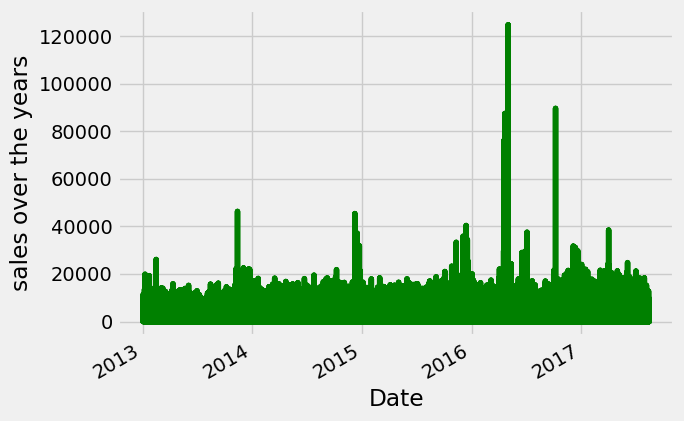

In [33]:
# Checking for seanality of sales of products over the years
oil_df.set_index("date")
plt.figure(figsize=(15,10))
train_data.plot(x="date", y="sales", color="green", legend=False)
plt.xlabel("Date")
plt.ylabel("sales over the years")
plt.style.use("fivethirtyeight")
plt.show()

From the visualization we can see there is seanality on the data set because towards the end of every year the sales always rise.

<b>  1. Distribusion of sales over the years <b>

In [34]:
sales_frequency    = train_data.groupby('year')['sales'].sum().reset_index()
sales_frequency = sales_frequency.sort_values(by='sales',ascending=False)
sales_frequency

,year,sales
3,2016,2.886545e+08
2,2015,2.408801e+08
1,2014,2.094742e+08
4,2017,1.942171e+08
0,2013,1.404190e+08


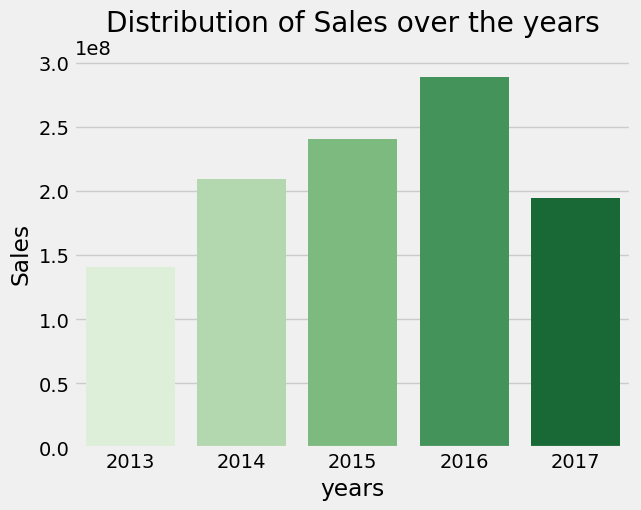

In [35]:
sns.barplot(x= 'year', y='sales', data= sales_frequency, palette="Greens")
plt.title('Distribution of Sales over the years')
plt.ylabel('Sales')
plt.xlabel('years')
plt.show()

# Multivariate Analysis

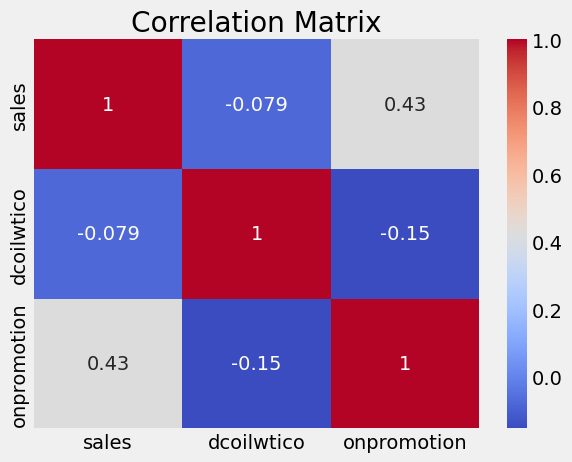

In [36]:
train_oil_data= train_data.merge(oil_df, on ='date', how='left') 
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'dcoilwtico', 'onpromotion']

# Compute correlation matrix
corr_matrix = train_oil_data[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Answering Questions and Hypotesis

##### 1. Is the train dataset complete (has all the required dates)?



In [37]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


From the above it is obvserverd that the dates in train data set is not complete some of the dates are missing which soposed to be christmas holidays that is 12-25 of every year

In [38]:
#  To complete the missing dates in the data set

# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_data = pd.concat([train_data, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_data.sort_values('date', inplace=True)


In [39]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


#### 2. Which dates have the lowest and highest sales for each year?

In [40]:

# Find the date with the lowest sales for each year
min_sales_dates = train_data.loc[train_data.groupby('year')['sales'].idxmin()][['year', 'date', 'month', 'sales']]

# Find the date with the highest sales for each year
max_sales_dates = train_data.loc[train_data.groupby('year')['sales'].idxmax()][['year', 'date', 'month', 'sales']]

print("Dates with the Lowest Sales for Each Year:")
print(min_sales_dates)

print("\nDates with the Highest Sales for Each Year:")
print(max_sales_dates)

Dates with the Lowest Sales for Each Year:
           year       date  month  sales
0        2013.0 2013-01-01    1.0    0.0
649832   2014.0 2014-01-01    1.0    0.0
1298484  2015.0 2015-01-01    1.0    0.0
1947132  2016.0 2016-01-01    1.0    0.0
2597563  2017.0 2017-01-01    1.0    0.0

Dates with the Highest Sales for Each Year:
           year       date  month       sales
562596   2013.0 2013-11-12   11.0   46271.000
1257246  2014.0 2014-12-08   12.0   45361.000
1916586  2015.0 2015-12-14   12.0   40351.460
2163723  2016.0 2016-05-02    5.0  124717.000
2760297  2017.0 2017-04-02    4.0   38422.625


### 3. Impact of April 16, 2016 earthquake on sales.

In [41]:
oil_sales_data = pd.merge(train_data, oil_df, on='date', how='left')
oil_sales_data = oil_sales_data.set_index('date')


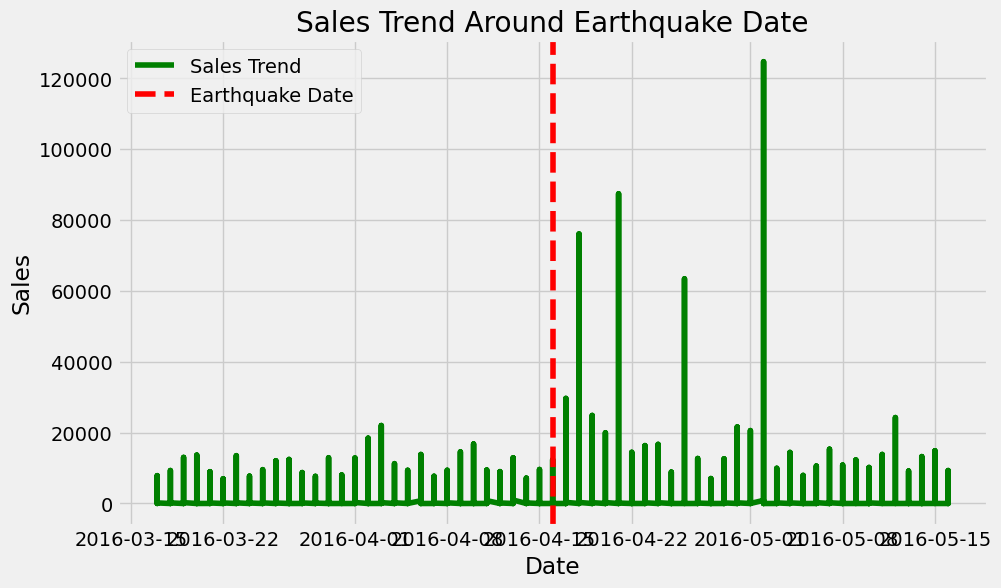

In [42]:

# Assuming 'oil_df' has a datetime index, if not, convert it
oil_sales_data.index = pd.to_datetime(oil_sales_data.index)

earthquake_date = pd.to_datetime('2016-04-16')
start_date = earthquake_date - pd.DateOffset(days=30)
end_date = earthquake_date + pd.DateOffset(days=30)

sales_around_earthquake = oil_sales_data.loc[(oil_sales_data.index >= start_date) & (oil_sales_data.index <= end_date)]

plt.figure(figsize=(10, 6))
plt.plot(sales_around_earthquake.index, sales_around_earthquake['sales'], color='green', label='Sales Trend')
plt.axvline(x=earthquake_date, color='red', linestyle='--', label='Earthquake Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Around Earthquake Date')
plt.legend()
plt.show()


## 4 Are certain groups of stores selling more products? (Cluster, city, state, type)

In [43]:
train_store_data = train_data.merge(stores_df, on='store_nbr', how='left')
top_sales = train_store_data.sort_values(by='sales', ascending=False)
top_10_sales= top_sales.head(20)

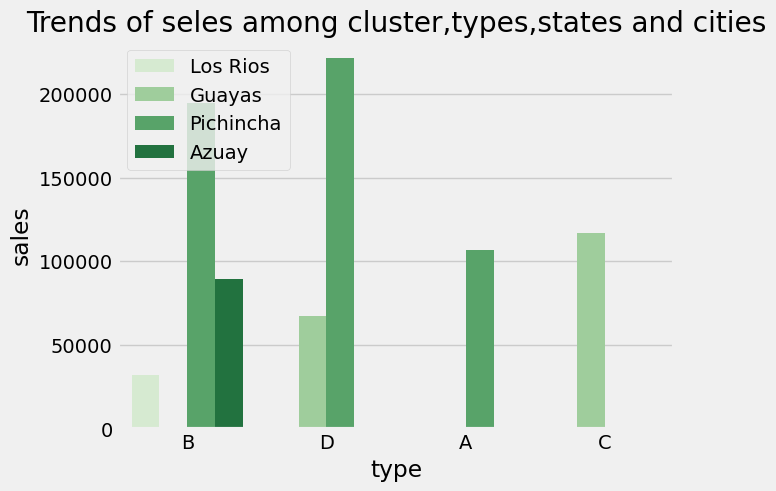

In [44]:
top_10_sales.set_index('date')

stores_sell_products = top_10_sales.groupby(["cluster", "city", "state", "type"])["sales"].sum().reset_index()
stores_sell_products = stores_sell_products.sort_values(by="sales")
sns.barplot(x='type', y='sales', hue='state', data=stores_sell_products, ci=None, palette='Greens')
plt.title('Trends of seles among cluster,types,states and cities')
plt.legend(loc='best')
plt.show()

## 5 Are sales affected by promotions, oil prices and holidays?

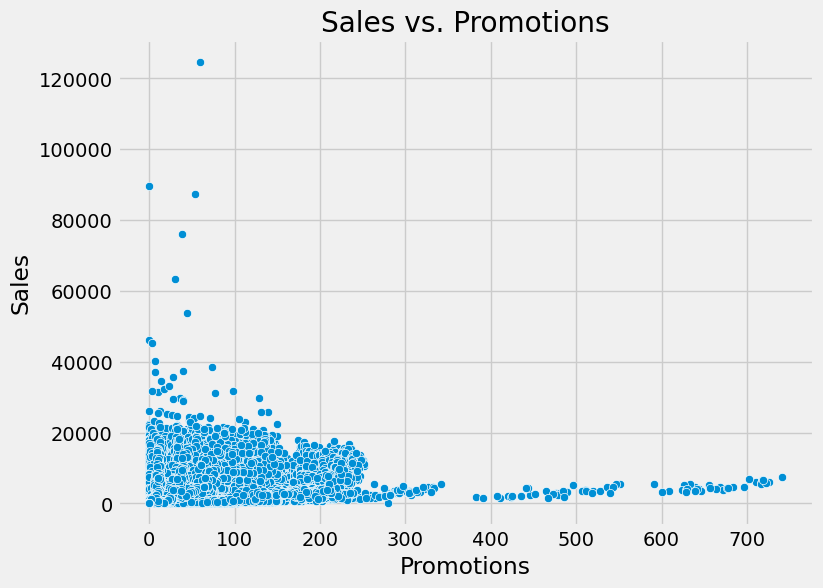

In [45]:
# Correlation analysis
correlation_promotions = train_data[['sales', 'onpromotion']].corr()

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='onpromotion', y='sales', data=train_data)
plt.title('Sales vs. Promotions')
plt.xlabel('Promotions')
plt.ylabel('Sales')
plt.show()

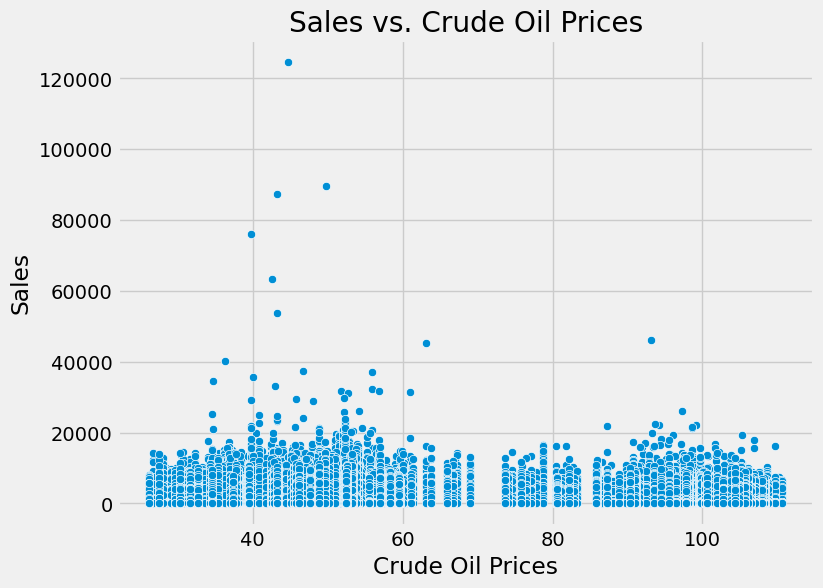

In [46]:


# Merge 'train' and 'oil' on 'date'
# merged_data = pd.merge(train_data, oil_df, on='date', how='left')

# Correlation analysis
correlation_oil_prices =train_oil_data[['sales', 'dcoilwtico']].corr()

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_oil_data, palette='Greens')
plt.title('Sales vs. Crude Oil Prices')
plt.xlabel('Crude Oil Prices')
plt.ylabel('Sales')
plt.show()


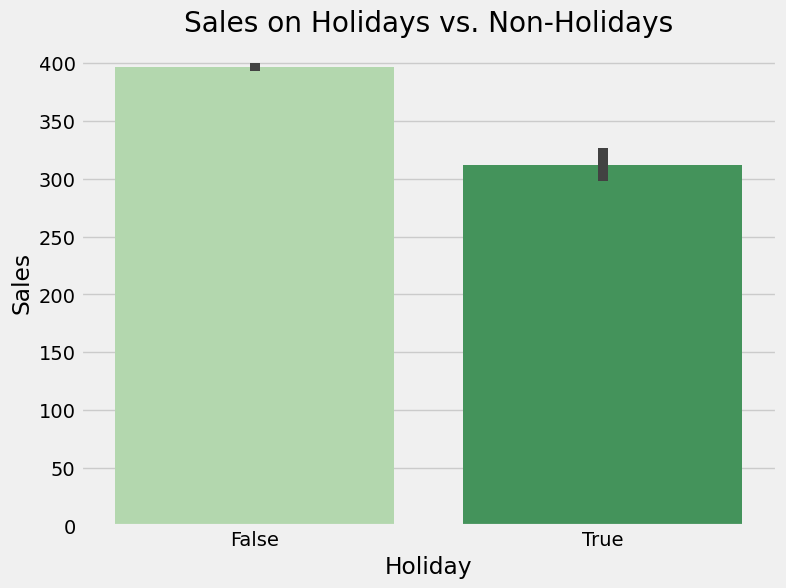

In [47]:



# Merge 'train' and 'holiday' on 'date'
merged_data_holidays = pd.merge(train_data, holiday_df, on='date', how='left')

# Correlation analysis
correlation_holidays = merged_data_holidays[['sales', 'transferred']].corr()

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='transferred', y='sales', data=merged_data_holidays, palette='Greens')
plt.title('Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday')
plt.ylabel('Sales')
plt.show()

# Hypotesis Testing

In [48]:

null_hyp = 'the type of holiday  have  significant effect on the increase of sales'
alt_hyp = 'the type of holiday has no significant effect on the increase of sales'
observed_value = pd.crosstab(merged_data_holidays['type'],merged_data_holidays['sales'])
chi2, p_value, dof, expected_value= stats.chi2_contingency(observed_value)
print('chi2:', chi2)
print('p_value:', p_value)
print('dof:', dof)
print('expected_value:',expected_value)
alpha= 0.1
if p_value <= alpha:
    print('The null hypothesis is rejected')
    print(alt_hyp)
else:
    print('The nul hypothesis is accepted')
    print(null_hyp)

chi2: 403717.71291712485
p_value: 1.8592877520968007e-169
dof: 379065
expected_value: [[2.03300000e+04 1.34751773e-01 1.34751773e-01 ... 2.69503546e-01
  1.34751773e-01 1.34751773e-01]
 [1.60500000e+03 1.06382979e-02 1.06382979e-02 ... 2.12765957e-02
  1.06382979e-02 1.06382979e-02]
 [2.99600000e+04 1.98581560e-01 1.98581560e-01 ... 3.97163121e-01
  1.98581560e-01 1.98581560e-01]
 [9.14850000e+04 6.06382979e-01 6.06382979e-01 ... 1.21276596e+00
  6.06382979e-01 6.06382979e-01]
 [4.81500000e+03 3.19148936e-02 3.19148936e-02 ... 6.38297872e-02
  3.19148936e-02 3.19148936e-02]
 [2.67500000e+03 1.77304965e-02 1.77304965e-02 ... 3.54609929e-02
  1.77304965e-02 1.77304965e-02]]
The null hypothesis is rejected
the type of holiday has no significant effect on the increase of sales


From the hypothesis the p_value is 1.8592877520968007e-169 which is greater than the alpha value o.1, this indicate that the type of holiday in the state does not determine increase if there will gbe increase in sales or not, therefore, sales of oil is the same even in the holiday

# Hypothesis Testing
#### Null Hypothesis (H0): The promotional activities have a significant impact on store sales.

##### Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.

In [49]:
# Extract the relevant variables for the hypothesis test
promo_sales = train_data[train_data['onpromotion'] == 1]['sales']
non_promo_sales = train_data[train_data['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)


from scipy.stats import ttest_ind

# Extract the relevant variables for the hypothesis test
promo_sales = train_data[train_data['onpromotion'] == 1]['sales']
non_promo_sales = train_data[train_data['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.")
print("Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on store sales .")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on store sales.")

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.
Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.
--------------------------------------------------
Test Statistic: 193.26843655143327
P-value: 0.0
Reject the null hypothesis. Promotional activities have a significant impact on store sales .


#### Summary of the Hypothesis

 hypothesis testing led to rejecting the null hypothesis, which means there's evidence that promotional activities do have a significant impact on store sales. That test statistic and p-value make a compelling case.It provides support for the alternative hypothesis, suggesting that there is a significant relationship between promotional activities and increased store sales. In practical terms, this implies that promotions indeed play a meaningful role in influencing customer behavior and boosting sales.

## Merging the data set for modelling

In [7]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_data1 = train_data.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_data2 = merged_data1.merge(transactions, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_data3 = merged_data2.merge(holiday_df, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_data = merged_data3.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


The use of an inner merge in this time series forecasting project helps to ensure data consistency, avoid missing values, and focus on the relevant data for accurate predictions.

An inner merge type retains only the rows with matching values in the specified columns. In the context of time series forecasting, it allows us to merge datasets based on a common time index or timestamp. By performing an inner merge, we ensure that only the rows with corresponding timestamps in both datasets are included in the merged result. This is important for time series forecasting because you want to align the data from different sources based on their timestamps to build a consistent and accurate forecasting model.

With an inner merge, you eliminate any non-matching timestamps, which may not be useful for forecasting and could introduce inconsistencies in the data. By focusing on the intersection of the datasets, we can create a merged dataset that contains the necessary information for accurate time series forecasting.

In [8]:
# checking for the info of the merged data
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            322047 non-null  int64  
 1   date          322047 non-null  object 
 2   store_nbr     322047 non-null  int64  
 3   family        322047 non-null  object 
 4   sales         322047 non-null  float64
 5   onpromotion   322047 non-null  int64  
 6   city          322047 non-null  object 
 7   state         322047 non-null  object 
 8   type_x        322047 non-null  object 
 9   cluster       322047 non-null  int64  
 10  transactions  322047 non-null  int64  
 11  type_y        322047 non-null  object 
 12  locale        322047 non-null  object 
 13  locale_name   322047 non-null  object 
 14  description   322047 non-null  object 
 15  transferred   322047 non-null  bool   
 16  dcoilwtico    322047 non-null  float64
dtypes: bool(1), float64(2), int64(5), object(9)
memo

from the information above we find out that there is change in some columns that is we have type_x, type_y, month_x, mmonth_y, year_x,year_y this is bgecause some they have the same cloumn name from different tables so we have to rename the type_x and type_y and drop the month_x and month_y because the are the same with the other ones

In [52]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_data['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_data['type_y'].unique())

Unique values of 'type_x':
['D' 'E' 'C' 'A' 'B']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [10]:
# Renaming the columns with the approapriate names
merged_df = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"}, inplace=True)
# drop month_x and year_x
merged_data.drop(columns= ['month_y', 'year_y'], axis=0, inplace=True)
merged_data.drop(columns= ['month_x', 'year_x'], axis=0, inplace=True)
merged_data.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


Checking for Missing Values in The Datasets

In [54]:
# Check for missing values in the merged datasets
merged_data.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

Checking for Duplicate Values in The Datasets

In [55]:
# Check for duplicate values in the merged dataset
merged_data.duplicated().sum()

0

There is no duplicate in the data set

# Checking for stationarity of the data
<b> using ADF
## Hypothesis
#### Null Hypothesis: the data is stationality
#### Alt Hypothesis:  The data is not stationality

<b> checking for stationarity using kpss

In [ ]:
# checking the stationarity of the data using the train data set
stat, p,lags, critical_values =kpss(train_data['sales'], 'ct')
print(f'Test statistics:',{stat})
print(f'P_value:',{p})
print(f'critical_values:,{critical_values}')
if p > 0.05:
    print('series is stationary')
else:
    print('series is not stationary')

In [ ]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
dtype: int64

In [ ]:
train_data.dropna(axis=0,inplace=True)

#### Summary

Test statistics: 2.147616512839002

P-value: 0.01

2.5% level: 0.176

1% level: 0.216

Based on the test results, since the p-value is less than the significance level (0.01), and the test statistic is greater than the critical value at the 1% level (2.147 > 0.216), we reject the null hypothesis of the test. Therefore, the series is stationary.

# Feature Enginering
<b> Train data set

<b>Extracting Date Components (Day of The Week).

In [11]:
# defining a function to etract year and month from the data column
def add_year_month_(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # Adjust the format according to your data
    df['year']= df["date"].dt.year
    df['month']=df["date"].dt.month
    df['day'] =df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek

In [12]:
# adding year and month, week and day to the train data
add_year_month_(merged_data)

In [13]:
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,locale,locale_name,description,transferred,dcoilwtico,year,month,day,week,day_of_week
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,National,Ecuador,Carnaval,False,97.010002,2013,2,11,7,0
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,National,Ecuador,Carnaval,False,97.010002,2013,2,11,7,0
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,National,Ecuador,Carnaval,False,97.010002,2013,2,11,7,0
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,...,National,Ecuador,Carnaval,False,97.010002,2013,2,11,7,0
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,National,Ecuador,Carnaval,False,97.010002,2013,2,11,7,0


In [14]:
# Define columns to drop
columns_to_drop = ['date', 'id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']

# Drop columns from DataFrame
merged_data_copy = merged_data.drop(columns=columns_to_drop, inplace=False)



In [ ]:
merged_data_copy

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,week,day_of_week
0,1,AUTOMOTIVE,0.00000,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
1,1,BABY CARE,0.00000,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
2,1,BEAUTY,0.00000,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
3,1,BEVERAGES,172.00000,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
4,1,BOOKS,0.00000,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,25,POULTRY,279.16998,0,Salinas,1,2202,Holiday,52.720001,2015,1,1,1,3
322043,25,PREPARED FOODS,121.94100,0,Salinas,1,2202,Holiday,52.720001,2015,1,1,1,3
322044,25,PRODUCE,105.00000,0,Salinas,1,2202,Holiday,52.720001,2015,1,1,1,3
322045,25,SCHOOL AND OFFICE SUPPLIES,0.00000,0,Salinas,1,2202,Holiday,52.720001,2015,1,1,1,3


## Feature Scaling

In [ ]:
# # Scaling Numeric Variables (Min-Max Scaling)
# # create an instance of StandardScaler
# scaler = StandardScaler()

# # select numerical columns
# num_cols = ['sales', 'transactions', 'dcoilwtico']

# # fit and transform the numerical columns
# merged_data_copy[num_cols] = scaler.fit_transform(merged_data_copy[num_cols])

# # Display the updated dataframe
# merged_data_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,week,day_of_week
0,1.0,AUTOMOTIVE,-0.325920,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,7,0
1,1.0,MAGAZINES,-0.325920,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,7,0
2,1.0,"LIQUOR,WINE,BEER",-0.309078,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,7,0
3,1.0,LINGERIE,-0.325920,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,7,0
4,1.0,LAWN AND GARDEN,-0.323514,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,7,0


In [15]:
# Define the category lists for each product category and group them together
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(food_families), 'FOODS',merged_data_copy['family'])
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(home_families), 'HOME', merged_data_copy['family'])
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(clothing_families), 'CLOTHING', merged_data_copy['family'])
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(grocery_families), 'GROCERY', merged_data_copy['family'])
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(stationery_families), 'STATIONERY', merged_data_copy['family'])
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(cleaning_families), 'CLEANING', merged_data_copy['family'])
merged_data_copy['family'] = np.where(merged_data_copy['family'].isin(hardware_families), 'HARDWARE', merged_data_copy['family'])

# Print the updated DataFrame
merged_data_copy.head()


,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,week,day_of_week
0,1,AUTOMOTIVE,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
1,1,CLEANING,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
2,1,BEAUTY,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
3,1,FOODS,172.0,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0
4,1,STATIONERY,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11,7,0


In [63]:
merged_data_copy.isna().sum()

store_nbr       0
family          0
sales           0
onpromotion     0
city            0
cluster         0
transactions    0
holiday_type    0
dcoilwtico      0
year            0
month           0
day             0
week            0
day_of_week     0
dtype: int64

# Encoding the categorical columns

In [16]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]
# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_data_copy[categorical_columns])
# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)
# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)
# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_data_copy, merged_df_encoded], axis=1)
# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)
# Print the head of the encoded DataFrame
merged_df_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,week,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,1,0.0,0,13,396,97.010002,2013,2,11,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.0,0,13,396,97.010002,2013,2,11,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.0,0,13,396,97.010002,2013,2,11,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,172.0,0,13,396,97.010002,2013,2,11,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.0,0,13,396,97.010002,2013,2,11,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Modelling

<b> seperating the train data and eval data

In [17]:
train_set=merged_df_encoded.loc[merged_df_encoded['year'].isin([2013,2014,2015,2016])]
eval_set=merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [18]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [ ]:
#  checking the shape of training and testing data
print('X_train_shape:', X_train.shape)
print('y_train_shape:', y_train.shape)
print('X_eval_shape:', X_eval.shape)
print('y_eval_shape:',y_eval.shape)

X_train_shape: (284889, 70)
y_train_shape: (284889,)
X_eval_shape: (37158, 70)
y_eval_shape: (37158,)


# Random Forest Regression

In [67]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt',max_depth=5,random_state=18).fit(X_train,y_train)

rf_pred= rf.predict(X_eval)
rf_mse= mean_squared_error(y_eval,rf_pred).round(2)
rf_rmse= rf_mse**.05
rf_msle = mean_squared_log_error(y_eval, rf_pred).round(2)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval,rf_pred)).round(2)
# Create a DataFrame to store results for ARIMA
rf_result = pd.DataFrame({'Model': ['RandomForest'],
                            'MSE': [rf_mse],
                            'RMSE': [rf_rmse],
                            'MSLE': [rf_msle],
                            'RMSLE': [rf_rmsle]}).round(2)

# Print the results_arima dataframe
rf_result

,Model,MSE,RMSE,MSLE,RMSLE
0,RandomForest,1112998.62,2.01,8.73,2.96


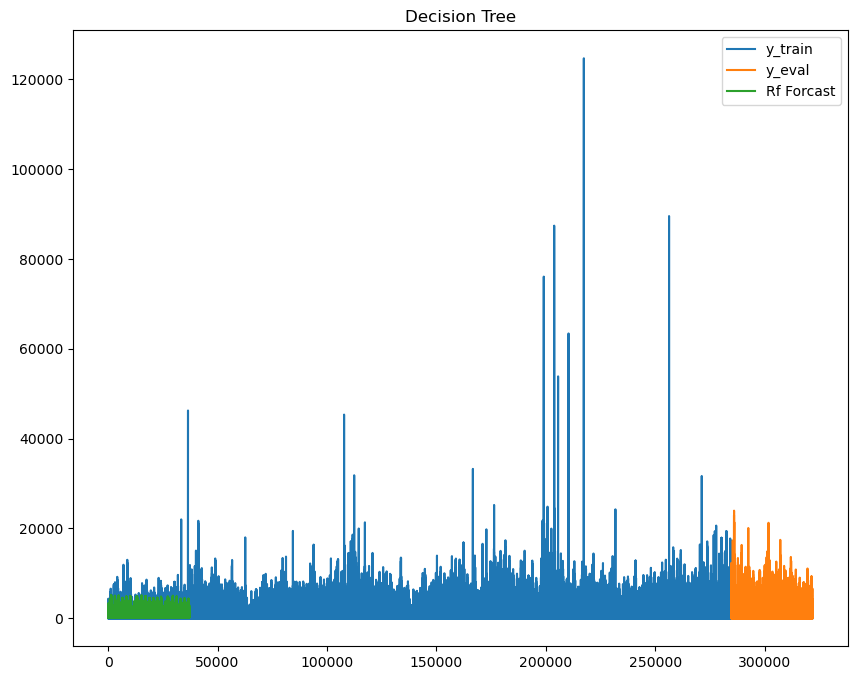

In [ ]:
# # Assuming X_eval is your feature matrix and y_eval is the target variable
# rf_importance = pd.DataFrame({'feature': X_eval.columns, 'y_eval': rf.feature_importances_})
# rf_importance.sort_values(by='y_eval', ascending=False, inplace=True)

# fig = px.bar(rf_importance, x='feature', y='y_eval')
# fig.show()
plt.figure(figsize=(10,8))
plt.plot(y_train, label= 'y_train')
plt.plot(y_eval, label='y_eval')
plt.plot(rf_pred, label='Rf Forcast')
plt.legend(loc="best")
plt.title('Decision Tree')
plt.show()


# Decision Tree Model

In [19]:
# Create an instance of DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=0)
dt_regressor.fit(X_train,y_train)

tree_pred= dt_regressor.predict(X_eval)
tree_mse= mean_squared_error(y_eval,tree_pred).round(2)
tree_rmse=np.sqrt(mean_squared_error(y_eval,tree_pred)).round(2)
tree_msle = mean_squared_log_error(y_eval, tree_pred).round(2)
tree_rmsle = np.sqrt(mean_squared_log_error(y_eval,tree_pred)).round(2)
# Create a DataFrame to store results for ARIMA
tree_result = pd.DataFrame({'Model': ['DecisionTree'],
                            'MSE': [tree_mse],
                            'RMSE': [tree_rmse],
                            'MSLE': [tree_msle],
                            'RMSLE': [tree_rmsle]})

# Print the results_arima dataframe
tree_result


,Model,MSE,RMSE,MSLE,RMSLE
0,DecisionTree,2099421.83,1448.94,1.85,1.36


# XGBOOST Model

In [ ]:
xgb_regresssor = XGBRegressor(max_leaves=0, random_state=0)
xgb_model =xgb_regresssor.fit(X_train,y_train, 
                                eval_metric=['rmsle','rmse'],
                                eval_set=[(X_eval,y_eval)],
                                verbose=100)
xgb_pred= dt_regressor.predict(X_eval)
xgb_mse= mean_squared_error(y_eval,xgb_pred).round(2)
xgb_rmse=np.sqrt(mean_squared_error(y_eval,xgb_pred)).round(2)
xgb_msle = mean_squared_log_error(y_eval, xgb_pred).round(2)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_eval,xgb_pred)).round(2)
# Create a DataFrame to store results for ARIMA
xgb_result = pd.DataFrame({'Model': ['XGBOOST'],
                            'MSE': [xgb_mse],
                            'RMSE': [xgb_rmse],
                            'MSLE': [xgb_msle],
                            'RMSLE': [xgb_rmsle]})

# Print the results_arima dataframe

xgb_result

[0]	validation_0-rmsle:3.20544	validation_0-rmse:1049.96156
[99]	validation_0-rmsle:nan	validation_0-rmse:798.13456


,Model,MSE,RMSE,MSLE,RMSLE
0,XGBOOST,1112660.78,1054.83,0.86,0.92


## Linear Regressor Model

In [20]:
from sklearn.linear_model import LinearRegression
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

lr_pred= dt_regressor.predict(X_eval)
lr_mse= mean_squared_error(y_eval,lr_pred).round(2)
lr_rmse=np.sqrt(mean_squared_error(y_eval,lr_pred)).round(2)
lr_msle = mean_squared_log_error(y_eval, lr_pred).round(2)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval,lr_pred)).round(2)
# Create a DataFrame to store results for ARIMA
lr_result = pd.DataFrame({'Model': ['Linear Regressor'],
                            'MSE': [lr_mse],
                            'RMSE': [lr_rmse],
                            'MSLE': [lr_msle],
                            'RMSLE': [lr_rmsle]})

# Print the results_arima dataframe

lr_result

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear Regressor,2099421.83,1448.94,1.85,1.36


# AR Model

In [ ]:
model= AutoReg(y_train ,lags=5).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:               284889
Model:                     AutoReg(5)   Log Likelihood            -2428520.432
Method:               Conditional MLE   S.D. of innovations           1218.841
Date:                Sun, 11 Feb 2024   AIC                        4857054.864
Time:                        18:34:54   BIC                        4857128.783
Sample:                             5   HQIC                       4857076.291
                               284889                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        314.6994      2.742    114.775      0.000     309.325     320.073
sales.L1       0.0875      0.002     46.845      0.000       0.084       0.091
sales.L2       0.0141      0.002      7.533      0.000       0.010       0.018
sales.L3      -0.0396      0.002    -21.200      0.000      -0.043      -0.036
sales.L4       0.0731      0.002     39.072      0.000       0.069       0.077
sales.L5       0.0712      0.002     38.081      0.000       0.068       0.075
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5221           -0.0000j            1.5221           -0.0000
AR.2            0.4239           -1.5158j            1.5740           -0.2066
AR.3            0.4239           +1.5158j            1.5740            0.2066
AR.4           -1.6986           -0.9171j            1.9304           -0.4212
AR.5           -1.6986           +0.9171j            1.9304            0.4212
-----------------------------------------------------------------------------
"""

In [ ]:
Ar_pred = model.predict(start = len(y_train),
                         end = len(y_train)+len(y_eval)-1,
                         dynamic= False
                         )

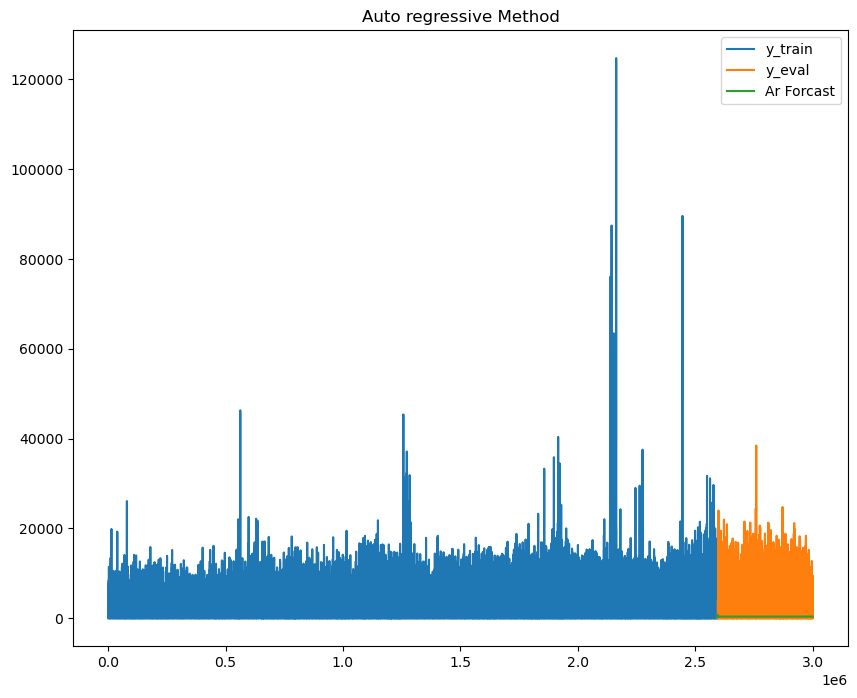

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_train, label= 'y_train')
plt.plot(y_eval, label='y_eval')
plt.plot(Ar_pred, label='Ar Forcast')
plt.legend(loc="best")
plt.title('Auto regressive Method')
plt.show()

In [ ]:
Ar_pred = model.predict(start = len(y_train),
                         end = len(y_train)+len(y_eval)-1,
                         dynamic= False
                         )
ar_mse= mean_squared_error(y_eval,Ar_pred)
ar_rmse=np.sqrt(mean_squared_error(y_eval,Ar_pred))
ar_msle = mean_squared_log_error(y_eval, Ar_pred)
ar_rmsle = np.sqrt(mean_squared_log_error(y_eval,Ar_pred))
Ar_result = pd.DataFrame({'Model': ['Ar Model'],
                            'MSE': [ar_mse],
                            'RMSE': [ar_rmse],
                            'MSLE': [ar_msle],
                            'RMSLE': [ar_rmsle]}).round(2)

Ar_result

,Model,MSE,RMSE,MSLE,RMSLE
0,Ar Model,1845156.32,1358.37,11.85,3.44


#  ARIMA MODEL

In [ ]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))
                    
# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_pred = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

arima_mse= mean_squared_error(y_eval,arima_pred)
arima_rmse=np.sqrt(mean_squared_error(y_eval,arima_pred))
arima_msle = mean_squared_log_error(y_eval, arima_pred)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval,arima_pred))
arima_result = pd.DataFrame({'Model': ['Arima Model'],
                            'MSE': [arima_mse],
                            'RMSE': [arima_rmse],
                            'MSLE': [arima_msle],
                            'RMSLE': [arima_rmsle]}).round(2)


# Print the results_arima dataframe
arima_result

,Model,MSE,RMSE,MSLE,RMSLE
0,Arima Model,1845156.98,1358.37,11.85,3.44


<b> Compering all the model together

In [ ]:
results = pd.DataFrame()
results = results.append(arima_result, ignore_index=True)
results = results.append(Ar_result, ignore_index=True)
results =results.append(tree_result, ignore_index=True)
results =results.append(rf_result, ignore_index=True)
results =results.append(xgb_result, ignore_index=True)
results =results.append(lr_result, ignore_index=True)

results


,Model,MSE,RMSE,MSLE,RMSLE
0,Arima Model,1845156.98,1358.37,11.85,3.44
1,Ar Model,1845156.32,1358.37,11.85,3.44
2,DecisionTree,1112660.78,1054.83,0.86,0.92
3,RandomForest,906939.70,1.99,8.82,2.97
4,XGBOOST,1112660.78,1054.83,0.86,0.92
5,Linear Regressor,1112660.78,1054.83,0.86,0.92


Summary of the Models
Arima Model and AR Model:

Both the Arima and AR models have the same performance metrics, indicating that they might be similar in terms of their predictive power. However, the RMSE and RMSLE values are relatively high, suggesting that these models might not be the best fit for the data.
Decision Tree, XGBoost, and Linear Regressor:

The Decision Tree, XGBoost, and Linear Regressor models have identical MSE, RMSE, MSLE, and RMSLE values.

The Random Forest model has the lowest MSE among all the models, indicating the best-performing model in terms of minimizing prediction errors.
Comparison:

The Decision Tree, XGBoost, and Linear Regressor models seem to perform similarly, but the Random Forest model stands out with a lower MSE. 

## Hyperparameter Tunning

In [69]:
# Define the parameter grid for tuning the random forest model
param_grid_rf = {
    'n_estimators': [100, 200,],
    'max_depth':  [10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                      n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_rf.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

# Make predictions using the best model
best_rf_predictions = best_rf_model.predict(X_eval)

# Calculate metrics for the best model
best_rf_mse = mean_squared_error(y_eval, best_rf_predictions)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_eval, best_rf_predictions)

# Apply absolute value to both predicted and target values
abs_best_rf_predictions = np.abs(best_rf_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_rf_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_rf_predictions))

# Create a DataFrame to store results for the best Random Forest model
best_results_rf = pd.DataFrame({'Model': ['Best Random Forest'],
                                'RMSLE': [best_rf_rmsle],
                                'RMSE': [best_rf_rmse],
                                'MSE': [best_rf_mse],
                                'MAE': [best_rf_mae]}).round(2)

# Print the best_results_rf dataframe
best_results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Best Random Forest,1.66,794.96,631965.18,313.41
